-=# Laboratory values vs outcome

Get the first laboratory measurements for patients admitted to the ICU. Plot the distribution of measurements for survival and non-survival groups.

In [12]:
# Import libraries
from __future__ import print_function

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import yaml
import os
from scipy.signal import medfilt
import tableone

# used to print out pretty pandas dataframes
from IPython.display import display, HTML

%matplotlib inline
plt.style.use('ggplot')

font = {'family' : 'DejaVu Sans',
        'size'   : 20}

matplotlib.rc('font', **font)

## Functions

# Load in merged GOSSIS data

In [2]:
df = pd.read_csv('gossis-data.csv',header=0,sep=",")
df['data_source'].value_counts()

/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2705: DtypeWarning: Columns (1,6,8,10,11,17,19,20,24,25,193) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


anzics       266136
eicu         122893
orchestra     59693
mimic         38139
nicst          3419
satiq           579
Name: data_source, dtype: int64

# Load in the header and the data type for each column

In [3]:
hdr = pd.read_csv('hdr/header.csv',header=None,sep=',')[0].values

# load yaml definitions
with open("hdr/variable-definitions.yaml", 'r') as stream:
    try:
        varlist = yaml.load(stream)
    except yaml.YAMLError as exc:
        print(exc)

# convert to dataframe
df_var = pd.DataFrame.from_dict(varlist, orient='index')
df_var['varname'] = df_var.index

# specify the order of the categories - data is output in this order
category_order = {'identifier': 1,
                  'demographic': 2,
                  'APACHE covariate': 3,
                  'vitals': 4,
                  'labs': 5,
                  'labs blood gas': 6,
                  'APACHE prediction': 10}
df_var['category_order'] = df_var['category'].map(category_order)

# sort df by the category, then by the variable name
df_var.sort_values(['category_order','varname'],inplace=True)

In [4]:
df_var['category'].value_counts()

vitals               64
labs                 60
demographic          28
APACHE covariate     25
labs blood gas       16
APACHE prediction     5
identifier            4
Name: category, dtype: int64

In [5]:
df_var['dataType'].value_counts()

numeric    167
string      15
binary      11
integer      9
Name: dataType, dtype: int64

# Data Processing

In [6]:
print(df[df['age']>150]['data_source'].value_counts())
df.loc[(df['age']>150)&(df['data_source']=='mimic'),'age']=91.4
print(df[df['age']>100]['data_source'].value_counts())

mimic        1959
orchestra       2
Name: data_source, dtype: int64
orchestra    65
anzics       32
Name: data_source, dtype: int64


# Comparisons

For comparisons, we are interested assessing each variable across the databases.

For numeric/integer variables:

* Compare the mean, median, standard deviation, 5th and 95th percentiles
* Plot the distribution using histograms

For string/binary (categorical) variables:

* Compare the categories to see if they overlap
* Compare the frequency of each category (cross-tab)

## Compare APACHE-III score in eicu and anzics patients

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


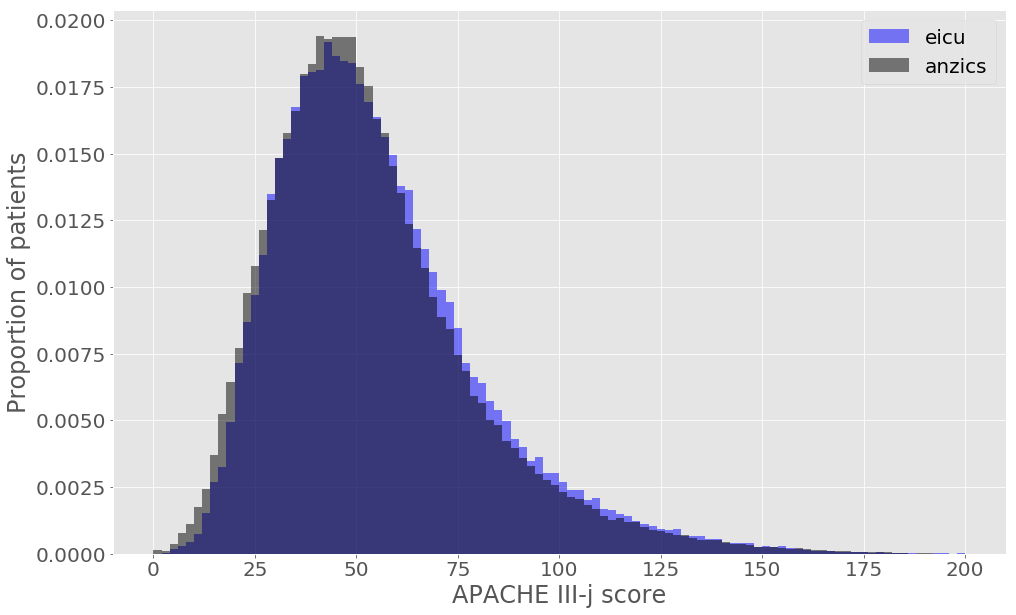

In [7]:
bins = np.linspace(0, 200, 101)
plt.figure(figsize=[16,10])
#plt.hist(df_all.loc[df_all['db']=='mimic','apsiii'].values, bins,
#         normed=True, alpha=0.5, label='mimic')
plt.hist(df.loc[df['data_source']=='eicu','apache_3j_score'].dropna().values, bins,
         normed=True, alpha=0.5, label='eicu', color = 'blue')
plt.hist(df.loc[df['data_source']=='anzics','apache_3j_score'].dropna().values, bins,
         normed=True, alpha=0.5, label='anzics', color= 'black')
plt.legend(loc='upper right')
plt.xlabel('APACHE III-j score')
plt.ylabel('Proportion of patients')
plt.show()

As we can see the distributions are very similar, though ANZICS seems to have lower acuity.

/usr/local/lib/python2.7/dist-packages/matplotlib/axes/_axes.py:6198: RuntimeWarning: invalid value encountered in true_divide
  m = (m.astype(float) / db) / m.sum()


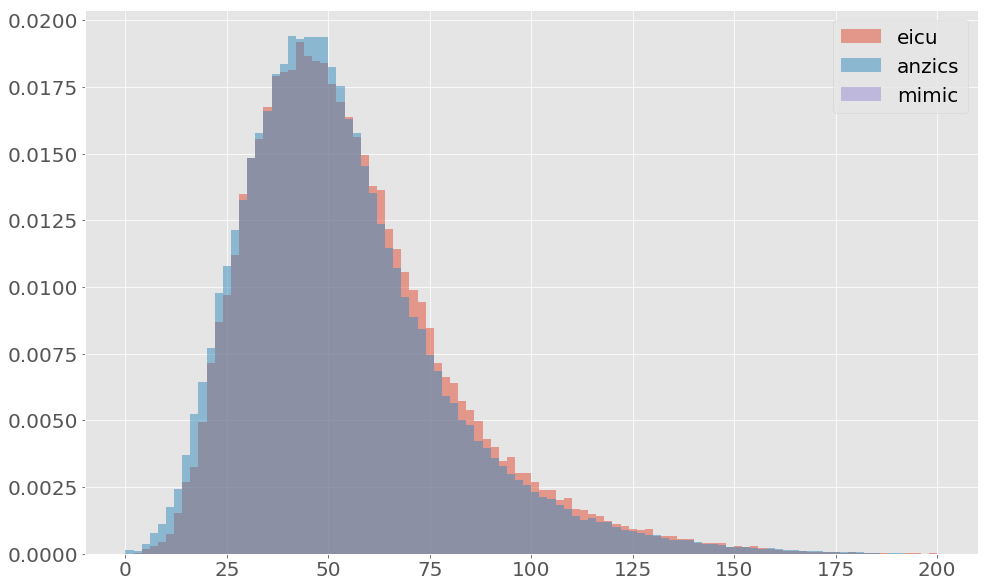

In [8]:
bins = np.linspace(0, 200, 101)
plt.figure(figsize=[16,10])
plt.rcParams.update({'font.size': 20})
plt.hist(df.loc[df['data_source']=='eicu','apache_3j_score'].dropna().values, bins,
         normed=True, alpha=0.5, label='eicu')
plt.hist(df.loc[df['data_source']=='anzics','apache_3j_score'].dropna().values, bins,
         normed=True, alpha=0.5, label='anzics')
plt.hist(df.loc[df['data_source']=='mimic','apache_3j_score'].dropna().values, bins,
         normed=True, alpha=0.5, label='mimic')
plt.legend(loc='upper right')
plt.show()

Note that we don't have any data for MIMIC for the APACHE-III score.

# Summarize dataset

In [15]:
categorical=['country', 'elective_surgery', 'ethnicity', 'gender', 'hospital_death', 'icu_death', 'pregnant', 'smoking_status', 'teaching_hospital', 'arf_apache', 'gcs_eyes_apache', 'gcs_motor_apache', 'gcs_unable_apache', 'gcs_verbal_apache', 'intubated_apache', 'ventilated_apache']
t1 = tableone.TableOne(df, columns=categorical, categorical=categorical, groupby='data_source')
t1

Stratified by data_source
                           anzics          eicu             mimic           nicst         orchestra       satiq           isnull
-------------------------  --------------  ---------------  --------------  ------------  --------------  ------------  --------
n                          266136          122893           38139           3419          59693           579                  0
country (n (%))                                                                                                                0
Australia                  240889 (90.51)  0 (0.00)         0 (0.00)        0 (0.00)      0 (0.00)        0 (0.00)
Bangladesh                 0 (0.00)        0 (0.00)         0 (0.00)        425 (12.43)   0 (0.00)        0 (0.00)
India                      0 (0.00)        0 (0.00)         0 (0.00)        2149 (62.85)  0 (0.00)        0 (0.00)
Nepal                      0 (0.00)        0 (0.00)         0 (0.00)        262 (7.66)    0 (0.00)        0 (0.00

## Cross-tabulate all categorical data

In [16]:
fac_list = df_var.loc[(df_var['dataType']!='numeric')&(df_var['category']!='identifier'),'varname']
for a in fac_list:
    if a in ['hospital_death','bmi','apache_3j_score','icu_id', 'hospital_bed_size_numeric', 'icu_admit_type', 'apsiii']:
        continue
    tbl = pd.crosstab(df[a], df['data_source'], margins = True)
    #display(HTML(tbl.to_html().replace('NaN', '')))
    #get percentage table
    tbl_perc = tbl/tbl.xs('All', axis=0)
    display(HTML(tbl_perc.to_html().replace('NaN', '')))

data_source,anzics,eicu,mimic,nicst,orchestra,satiq,All
country,,,,,,,
Australia,240889,0,0,0,0,0,240889
Bangladesh,0,0,0,425,0,0,425
India,0,0,0,2149,0,0,2149
Nepal,0,0,0,262,0,0,262
New Zealand,25247,0,0,0,0,0,25247
Sri Lanka,0,0,0,583,0,0,583
USA,0,122893,38139,0,0,0,161032
argentina,0,0,0,0,0,579,579
brazil,0,0,0,0,59693,0,59693


data_source,anzics,eicu,mimic,nicst,orchestra,satiq,All
country,,,,,,,
Australia,0.905135,0.0,0.0,0.000000,0.0,0.0,0.490750
Bangladesh,0.000000,0.0,0.0,0.124305,0.0,0.0,0.000866
India,0.000000,0.0,0.0,0.628546,0.0,0.0,0.004378
Nepal,0.000000,0.0,0.0,0.076631,0.0,0.0,0.000534
New Zealand,0.094865,0.0,0.0,0.000000,0.0,0.0,0.051434
Sri Lanka,0.000000,0.0,0.0,0.170518,0.0,0.0,0.001188
USA,0.000000,1.0,1.0,0.000000,0.0,0.0,0.328062
argentina,0.000000,0.0,0.0,0.000000,0.0,1.0,0.001180
brazil,0.000000,0.0,0.0,0.000000,1.0,0.0,0.121609


data_source,anzics,eicu,mimic,orchestra,satiq,All
elective_surgery,,,,,,
0.0,147616,100757,32099,43041,224,323737
1.0,118084,22136,6040,16652,355,163267
All,265700,122893,38139,59693,579,487004


data_source,anzics,eicu,mimic,orchestra,satiq,All
elective_surgery,,,,,,
0.0,0.555574,0.819876,0.841632,0.721039,0.386874,0.664752
1.0,0.444426,0.180124,0.158368,0.278961,0.613126,0.335248
All,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


data_source,anzics,eicu,mimic,All
ethnicity,,,,
African American,0,14886,2920,17806
Asian,0,1564,902,2466
Caucasian,0,94171,27218,121389
Hispanic,0,4383,1289,5672
Indigenous,17611,0,0,17611
Native American,0,935,20,955
Other/Unknown,0,5453,5790,11243
All,17611,121392,38139,177142


data_source,anzics,eicu,mimic,All
ethnicity,,,,
African American,0.0,0.122628,0.076562,0.100518
Asian,0.0,0.012884,0.023650,0.013921
Caucasian,0.0,0.775760,0.713653,0.685264
Hispanic,0.0,0.036106,0.033797,0.032020
Indigenous,1.0,0.000000,0.000000,0.099417
Native American,0.0,0.007702,0.000524,0.005391
Other/Unknown,0.0,0.044921,0.151813,0.063469
All,1.0,1.000000,1.000000,1.000000


data_source,anzics,eicu,mimic,nicst,orchestra,satiq,All
gender,,,,,,,
F,113519,56478,16554,1190,29911,254,217906
M,152596,66383,21585,2198,29773,325,272860
All,266115,122861,38139,3388,59684,579,490766


data_source,anzics,eicu,mimic,nicst,orchestra,satiq,All
gender,,,,,,,
F,0.426579,0.45969,0.434044,0.35124,0.501156,0.438687,0.444012
M,0.573421,0.54031,0.565956,0.64876,0.498844,0.561313,0.555988
All,1.000000,1.00000,1.000000,1.00000,1.000000,1.000000,1.000000


data_source,anzics,eicu,mimic,All
hospital_admit_source,,,,
Acute Care/Floor,0,2105,2,2107
Chest Pain Center,0,274,0,274
Chronic Care Hospital (including nursing homes),1960,0,0,1960
Direct Admit,0,8418,14361,22779
Emergency Department,0,49735,16526,66261
Floor,0,10443,0,10443
Home,204177,0,0,204177
ICU,0,40,0,40
ICU to SDU,0,56,0,56


data_source,anzics,eicu,mimic,All
hospital_admit_source,,,,
Acute Care/Floor,0.000000,0.022750,0.000052,0.005515
Chest Pain Center,0.000000,0.002961,0.000000,0.000717
Chronic Care Hospital (including nursing homes),0.007797,0.000000,0.000000,0.005130
Direct Admit,0.000000,0.090978,0.376544,0.059622
Emergency Department,0.000000,0.537513,0.433310,0.173433
Floor,0.000000,0.112863,0.000000,0.027334
Home,0.812195,0.000000,0.000000,0.534416
ICU,0.000000,0.000432,0.000000,0.000105
ICU to SDU,0.000000,0.000605,0.000000,0.000147


data_source,eicu,mimic,orchestra,All
hospital_bed_size,,,,
100 - 249,26124,0,31487,57611
250 - 499,23973,0,15576,39549
<100,5771,0,6991,12762
>= 500,53115,38139,5639,96893
All,108983,38139,59693,206815


data_source,eicu,mimic,orchestra,All
hospital_bed_size,,,,
100 - 249,0.239707,0.0,0.527482,0.278563
250 - 499,0.219970,0.0,0.260935,0.191229
<100,0.052953,0.0,0.117116,0.061707
>= 500,0.487370,1.0,0.094467,0.468501
All,1.000000,1.0,1.000000,1.000000


data_source,anzics,eicu,mimic,orchestra,satiq,All
hospital_disch_location,,,,,,
Alta domiciliaria,0,0,0,0,435,435
Death,0,10809,4201,0,0,15010
Died in Hospital,21731,0,0,8228,0,29959
Discharged home,191505,0,0,354,0,191859
Fallece,0,0,0,0,97,97
Home,0,72684,19967,0,0,92651
Nursing Home,0,887,389,0,0,1276
Other,0,5484,198,0,0,5682
Other External,0,5808,78,0,0,5886


data_source,anzics,eicu,mimic,orchestra,satiq,All
hospital_disch_location,,,,,,
Alta domiciliaria,0.000000,0.000000,0.000000,0.000000,0.808550,0.000898
Death,0.000000,0.087955,0.110150,0.000000,0.000000,0.030990
Died in Hospital,0.081755,0.000000,0.000000,0.144404,0.000000,0.061853
Discharged home,0.720466,0.000000,0.000000,0.006213,0.000000,0.396112
Fallece,0.000000,0.000000,0.000000,0.000000,0.180297,0.000200
Home,0.000000,0.591441,0.523532,0.000000,0.000000,0.191287
Nursing Home,0.000000,0.007218,0.010200,0.000000,0.000000,0.002634
Other,0.000000,0.044624,0.005192,0.000000,0.000000,0.011731
Other External,0.000000,0.047261,0.002045,0.000000,0.000000,0.012152


data_source,anzics,All
hospital_type,,
Metropolitan,44461,44461
Private,72372,72372
Rural / Regional,35786,35786
Tertiary,113517,113517
All,266136,266136


data_source,anzics,All
hospital_type,,
Metropolitan,0.167061,0.167061
Private,0.271936,0.271936
Rural / Regional,0.134465,0.134465
Tertiary,0.426538,0.426538
All,1.000000,1.000000


data_source,anzics,eicu,orchestra,satiq,All
icu_admit_source,,,,,
0.0,0,0,0,26,26
1.0,0,0,0,65,65
2.0,0,0,0,104,104
4.0,0,0,0,1,1
5.0,0,0,0,2,2
6.0,0,0,0,1,1
7.0,0,0,0,259,259
9.0,0,0,0,2,2
10.0,0,0,0,104,104


data_source,anzics,eicu,orchestra,satiq,All
icu_admit_source,,,,,
0.0,0.000000,0.000000,0.000000,0.044905,0.000058
1.0,0.000000,0.000000,0.000000,0.112263,0.000145
2.0,0.000000,0.000000,0.000000,0.179620,0.000232
4.0,0.000000,0.000000,0.000000,0.001727,0.000002
5.0,0.000000,0.000000,0.000000,0.003454,0.000004
6.0,0.000000,0.000000,0.000000,0.001727,0.000002
7.0,0.000000,0.000000,0.000000,0.447323,0.000577
9.0,0.000000,0.000000,0.000000,0.003454,0.000004
10.0,0.000000,0.000000,0.000000,0.179620,0.000232


data_source,anzics,eicu,mimic,nicst,orchestra,satiq,All
icu_death,,,,,,,
0.0,251602,116019,35174,2472,53970,525,459762
1.0,13945,6874,2965,947,5722,54,30507
All,265547,122893,38139,3419,59692,579,490269


data_source,anzics,eicu,mimic,nicst,orchestra,satiq,All
icu_death,,,,,,,
0.0,0.947486,0.944065,0.922258,0.723018,0.904141,0.906736,0.937775
1.0,0.052514,0.055935,0.077742,0.276982,0.095859,0.093264,0.062225
All,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


data_source,anzics,eicu,orchestra,satiq,All
icu_disch_location,,,,,
1.0,0,0,0,490,490
2.0,0,0,0,30,30
4.0,0,0,0,5,5
5.0,0,0,0,54,54
Acute Care/Floor,0,13549,0,0,13549
Death,0,6874,0,0,6874
Died in ICU,13945,0,5665,0,19610
Floor,0,60655,0,0,60655
Home,0,11358,0,0,11358


data_source,anzics,eicu,orchestra,satiq,All
icu_disch_location,,,,,
1.0,0.000000,0.000000,0.000000,0.846287,0.001093
2.0,0.000000,0.000000,0.000000,0.051813,0.000067
4.0,0.000000,0.000000,0.000000,0.008636,0.000011
5.0,0.000000,0.000000,0.000000,0.093264,0.000120
Acute Care/Floor,0.000000,0.110266,0.000000,0.000000,0.030215
Death,0.000000,0.055943,0.000000,0.000000,0.015329
Died in ICU,0.052514,0.000000,0.095338,0.000000,0.043731
Floor,0.000000,0.493628,0.000000,0.000000,0.135263
Home,0.000000,0.092435,0.000000,0.000000,0.025329


data_source,anzics,eicu,mimic,All
icu_stay_type,,,,
CMED,0,0,4399,4399
CSURG,0,0,6191,6191
DENT,0,0,5,5
ENT,0,0,122,122
GU,0,0,206,206
GYN,0,0,122,122
HDU,69838,0,0,69838
ICU,196104,0,0,196104
MED,0,0,12980,12980


data_source,anzics,eicu,mimic,All
icu_stay_type,,,,
CMED,0.000000,0.000000,0.120975,0.010346
CSURG,0.000000,0.000000,0.170255,0.014560
DENT,0.000000,0.000000,0.000138,0.000012
ENT,0.000000,0.000000,0.003355,0.000287
GU,0.000000,0.000000,0.005665,0.000484
GYN,0.000000,0.000000,0.003355,0.000287
HDU,0.262606,0.000000,0.000000,0.164248
ICU,0.737394,0.000000,0.000000,0.461206
MED,0.000000,0.000000,0.356956,0.030527


data_source,eicu,mimic,orchestra,All
icu_type,,,,
1,0,0,45663,45663
2,0,0,4576,4576
3,0,0,1147,1147
4,0,0,1199,1199
5,0,0,3871,3871
6,0,0,325,325
1,0,0,2831,2831
5,0,0,81,81
CCU,0,5638,0,5638


data_source,eicu,mimic,orchestra,All
icu_type,,,,
1,0.000000,0.000000,0.764964,0.206877
2,0.000000,0.000000,0.076659,0.020732
3,0.000000,0.000000,0.019215,0.005197
4,0.000000,0.000000,0.020086,0.005432
5,0.000000,0.000000,0.064848,0.017538
6,0.000000,0.000000,0.005445,0.001472
1,0.000000,0.000000,0.047426,0.012826
5,0.000000,0.000000,0.001357,0.000367
CCU,0.000000,0.147828,0.000000,0.025543


data_source,anzics,mimic,All
pregnant,,,
0.0,38393,1929,40322
1.0,702,24,726
All,39095,1953,41048


data_source,anzics,mimic,All
pregnant,,,
0.0,0.982044,0.987711,0.982313
1.0,0.017956,0.012289,0.017687
All,1.000000,1.000000,1.000000


data_source,anzics,eicu,mimic,orchestra,satiq,All
readmission_status,,,,,,
0.0,266136,122893,38077,59693,550,487349
1.0,0,0,62,0,29,91
All,266136,122893,38139,59693,579,487440


data_source,anzics,eicu,mimic,orchestra,satiq,All
readmission_status,,,,,,
0.0,1.0,1.0,0.998374,1.0,0.949914,0.999813
1.0,0.0,0.0,0.001626,0.0,0.050086,0.000187
All,1.0,1.0,1.000000,1.0,1.000000,1.000000


data_source,anzics,mimic,All
smoking_status,,,
Current Smoker,18809,18043,36852
Ex-Smoker,31731,274,32005
Never Smoked,28870,10870,39740
Unknown,0,8952,8952
All,79410,38139,117549


data_source,anzics,mimic,All
smoking_status,,,
Current Smoker,0.236859,0.473085,0.313503
Ex-Smoker,0.399584,0.007184,0.272269
Never Smoked,0.363556,0.285010,0.338072
Unknown,0.000000,0.234720,0.076155
All,1.000000,1.000000,1.000000


data_source,anzics,eicu,mimic,All
teaching_hospital,,,,
0.0,90228,84715,0,174943
1.0,175908,38178,38139,252225
All,266136,122893,38139,427168


data_source,anzics,eicu,mimic,All
teaching_hospital,,,,
0.0,0.33903,0.68934,0.0,0.409541
1.0,0.66097,0.31066,1.0,0.590459
All,1.00000,1.00000,1.0,1.000000


data_source,anzics,eicu,satiq,All
arf_apache,,,,
0,253476,118544,0,372020
1,12660,4349,0,17009
N,0,0,505,505
S,0,0,74,74
All,266136,122893,579,389608


data_source,anzics,eicu,satiq,All
arf_apache,,,,
0,0.95243,0.964611,0.000000,0.954857
1,0.04757,0.035389,0.000000,0.043657
N,0.00000,0.000000,0.872193,0.001296
S,0.00000,0.000000,0.127807,0.000190
All,1.00000,1.000000,1.000000,1.000000


data_source,anzics,eicu,mimic,All
gcs_eyes_apache,,,,
1.0,20511,10741,6062,37314
2.0,5970,6105,2058,14133
3.0,29547,18446,9826,57819
4.0,201996,86286,19995,308277
All,258024,121578,37941,417543


data_source,anzics,eicu,mimic,All
gcs_eyes_apache,,,,
1.0,0.079493,0.088347,0.159774,0.089366
2.0,0.023137,0.050215,0.054242,0.033848
3.0,0.114513,0.151722,0.258981,0.138474
4.0,0.782857,0.709717,0.527002,0.738312
All,1.000000,1.000000,1.000000,1.000000


data_source,anzics,eicu,mimic,All
gcs_motor_apache,,,,
1.0,15508,7116,3865,26489
2.0,1189,464,186,1839
3.0,1552,742,197,2491
4.0,4777,6380,1903,13060
5.0,11241,10132,4169,25542
6.0,223780,96744,27465,347989
All,258047,121578,37785,417410


data_source,anzics,eicu,mimic,All
gcs_motor_apache,,,,
1.0,0.060098,0.058530,0.102289,0.063460
2.0,0.004608,0.003816,0.004923,0.004406
3.0,0.006014,0.006103,0.005214,0.005968
4.0,0.018512,0.052477,0.050364,0.031288
5.0,0.043562,0.083337,0.110335,0.061192
6.0,0.867206,0.795736,0.726876,0.833686
All,1.000000,1.000000,1.000000,1.000000


data_source,eicu,mimic,All
gcs_unable_apache,,,
0.0,121578,28904,150482
1.0,1315,9115,10430
All,122893,38019,160912


data_source,eicu,mimic,All
gcs_unable_apache,,,
0.0,0.9893,0.760251,0.935182
1.0,0.0107,0.239749,0.064818
All,1.0000,1.000000,1.000000


data_source,anzics,eicu,mimic,All
gcs_verbal_apache,,,,
1.0,24248,21938,3219,49405
2.0,6087,2679,1058,9824
3.0,6029,4270,362,10661
4.0,21463,15089,4341,40893
5.0,200195,77602,28816,306613
All,258022,121578,37796,417396


data_source,anzics,eicu,mimic,All
gcs_verbal_apache,,,,
1.0,0.093976,0.180444,0.085168,0.118365
2.0,0.023591,0.022035,0.027992,0.023536
3.0,0.023366,0.035121,0.009578,0.025542
4.0,0.083183,0.124110,0.114853,0.097972
5.0,0.775883,0.638290,0.762409,0.734585
All,1.000000,1.000000,1.000000,1.000000


data_source,anzics,eicu,All
intubated_apache,,,
0.0,174095,103736,277831
1.0,92040,19157,111197
All,266135,122893,389028


data_source,anzics,eicu,All
intubated_apache,,,
0.0,0.65416,0.844116,0.714167
1.0,0.34584,0.155884,0.285833
All,1.00000,1.000000,1.000000


data_source,anzics,eicu,mimic,nicst,orchestra,satiq,All
ventilated_apache,,,,,,,
0.0,169440,93261,20425,2123,50458,568,336275
1.0,96696,29632,17714,689,9064,11,153806
All,266136,122893,38139,2812,59522,579,490081


data_source,anzics,eicu,mimic,nicst,orchestra,satiq,All
ventilated_apache,,,,,,,
0.0,0.636667,0.75888,0.535541,0.754979,0.84772,0.981002,0.686162
1.0,0.363333,0.24112,0.464459,0.245021,0.15228,0.018998,0.313838
All,1.000000,1.00000,1.000000,1.000000,1.00000,1.000000,1.000000


# Completion table

In [17]:
index = list(df_var['category'].astype('category').cat.categories)
category_gp=df_var.groupby('category')
header=['anzics','eicu','mimic','orchestra']

for i in index:
    display(HTML('<h2>'+i+'</h2>'))
    comp_dict={}
    for column in df_var.loc[df_var['category']==i,'varname']:
        if column in ['data_source','hospital_bed_size_numeric','icu_admit_type']:
            continue
        comp_dict[column] = list()
            
        for dataname in header:
            N = np.sum(df['data_source']==dataname)
            N_COUNT = df.loc[df['data_source']==dataname,column].count()
            if N>0:
                comp_dict[column].append( N_COUNT*100.0/N )
                
    tb = pd.DataFrame(comp_dict, index=header)
    tb = tb.replace(to_replace=float(0), value='')
    tb=tb.transpose()
    display(HTML(tb.to_html()))
    tb.to_csv(i+'-completion.csv',index=True)

,anzics,eicu,mimic,orchestra
albumin_apache,93.5788,39.0462,35.4493,
arf_apache,100,100,,
bilirubin_apache,90.0806,35.3283,42.8616,
bun_apache,96.5454,79.8329,99.3314,
creatinine_apache,97.1368,80.2519,99.3497,
fio2_apache,76.5751,23.7174,39.6078,
gcs_eyes_apache,96.9519,98.93,99.4808,
gcs_motor_apache,96.9606,98.93,99.0718,
gcs_unable_apache,,100,99.6854,
gcs_verbal_apache,96.9512,98.93,99.1007,


,anzics,eicu,mimic,orchestra
apache_3j_hospital_death_prob,100,,,
apache_3j_score,100,100,,
apache_4a_hospital_death_prob,,100,,
apache_4a_icu_death_prob,,100,,
apsiii,100,100,100,


,anzics,eicu,mimic,orchestra
age,100,96.4611,100,100
bmi,31.3186,96.711,41.5795,58.0571
country,100,100,100,100
elective_surgery,99.8362,100,100,100
ethnicity,6.61729,98.7786,100,
gender,99.9921,99.974,100,99.9849
height,31.5996,98.7379,41.7132,58.6585
hospital_admit_source,94.4588,75.2915,100,
hospital_bed_size,,88.6812,100,100
hospital_death,99.8764,100,100,100


,anzics,eicu,mimic,orchestra
encounter_id,100.0,100.0,100.0,100.0
hospital_id,100.0,100.0,100.0,100.0
patient_id,100.0,100.0,100.0,100.0


,anzics,eicu,mimic,orchestra
d1_albumin_max,,44.6112,28.4486,
d1_albumin_min,,44.6112,28.4486,
d1_bilirubin_max,,40.4596,34.8856,
d1_bilirubin_min,,40.4596,34.8856,
d1_bun_max,,89.4616,98.1017,
d1_bun_min,,89.4616,98.1017,
d1_calcium_max,,87.066,81.7011,
d1_calcium_min,,87.066,81.7011,
d1_creatinine_max,97.0008,89.8334,98.1331,
d1_creatinine_min,90.7138,89.8334,98.1331,


,anzics,eicu,mimic,orchestra
d1_arterial_pco2_max,,36.186,56.9653,
d1_arterial_pco2_min,,36.186,56.9653,
d1_arterial_ph_max,,35.4772,56.9653,
d1_arterial_ph_min,,35.4772,56.9653,
d1_arterial_po2_max,,36.2104,56.9653,
d1_arterial_po2_min,,36.2104,56.9653,
d1_pao2fio2ratio_max,,27.8258,45.9425,
d1_pao2fio2ratio_min,,27.8258,45.9425,
h1_arterial_pco2_max,,17.5242,31.5006,37.4064
h1_arterial_pco2_min,,17.5242,31.5006,11.6295


,anzics,eicu,mimic,orchestra
d1_diasbp_invasive_max,,26.8477,50.5283,
d1_diasbp_invasive_min,,26.8477,50.5283,
d1_diasbp_max,98.1957,99.9577,99.7037,
d1_diasbp_min,98.6319,99.9577,99.7037,
d1_diasbp_noninvasive_max,,98.8974,86.7196,
d1_diasbp_noninvasive_min,,98.8974,86.7196,
d1_heartrate_max,100,99.9919,99.785,
d1_heartrate_min,100,99.9919,99.785,
d1_mbp_invasive_max,,27.0007,51.3202,
d1_mbp_invasive_min,,27.0007,51.3202,


# Ventilated vs Not

# Compare Hospital Death vs No Hospital Death

In [18]:
fac_list = df_var.loc[(df_var['dataType']!='numeric')&(df_var['category']!='identifier'),'varname']
for a in fac_list:
    if a in ['hospital_death','bmi','apache_3j_score','icu_id', 'hospital_bed_size_numeric', 'icu_admit_type', 'apsiii']:
        continue
    tbl = pd.crosstab(df[a], [df['data_source'],df['hospital_death']], margins = True)
    #get percentage table
    tbl_perc = tbl*100.0/tbl.xs('All', axis=0)
    display(HTML(tbl_perc.to_html()))

# Day 1 vs Hour 1

# About Databases (Demographics)

In [20]:
categorical = ['elective_surgery', 'gender', 'hospital_death', 'icu_death', 'pregnant', 'readmission_status', 'smoking_status', 'teaching_hospital']
continuous = ['age', 'height', 'hospital_los_days', 'icu_los_days', 'pre_icu_los_days', 'weight']

t1 = tableone.TableOne(df, columns=categorical + continuous, categorical=categorical, groupby = 'data_source', pval=False)
t1

Stratified by data_source
                                anzics           eicu             mimic           nicst           orchestra       satiq            isnull
------------------------------  ---------------  ---------------  --------------  --------------  --------------  -------------  --------
n                               266136           122893           38139           3419            59693           579                   0
age (mean (std))                61.55 (17.86)    61.96 (16.63)    63.81 (17.67)   nan (nan)       62.33 (19.33)   59.25 (13.66)      7768
height (mean (std))             169.26 (11.44)   169.40 (13.90)   169.56 (11.75)  153.12 (17.35)  165.89 (10.83)  nan (nan)        234063
hospital_los_days (mean (std))  14.41 (72.63)    6.82 (9.07)      9.92 (10.71)    nan (nan)       15.63 (29.06)   0.15 (2.07)        3553
icu_los_days (mean (std))       3.02 (5.08)      2.95 (3.96)      4.10 (6.04)     4.75 (8.74)     5.01 (9.14)     4.74 (14.75)        807
pre_icu_